## Component 3. Topic Evolution in NIPS dataset

### Dynamic topic model(DTM) componet
Running preprocess and DTM model took approximate 3 hours on my notebook. So I wrote out topic evolution(topic*.csv) and distribution(distribution.csv) to csv files for visualization.

First we wil setup logging.

In [12]:
import logging
import os
import tempfile

from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
import numpy as np

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

if not os.environ.get('DTM_PATH', None):
    raise ValueError("SKIP: You need to set the DTM path")

2017-09-21 23:16:44,841 : DEBUG : test


Folder "/var/folders/sc/60xh0vg57737sf1sljkrygn40000gn/T" will be used to save temporary dictionary and corpus.


Then load the paper texts as documents and record the time sequence of each year.

In [1]:
import pandas as pd

input = '/Users/lillian/Documents/workspace/ir/data/papers.csv'
df = pd.read_csv(input)
df.columns.get_values()
documents = df['paper_text']
documents.tolist()

paper_year=df.groupby(['year']).size()
time_seq = paper_year.tolist()

Natural Language Toolkit (NLTK) is applied to preprocess the documents. The process including remove stop words, remove non-letters, convert letters to lower-case, remove all single-letter words and tokenise string.

In [57]:
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.corpus import inaugural
from string import punctuation
from nltk.corpus import inaugural
from gensim import models, corpora, similarities
from nltk.stem.porter import PorterStemmer

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()
#nltk.download()
#create another function to preprocess the file
def process_documents(corpus): 
	stops = stopwords.words('english')
	stops.extend(['figure','fig','pp','number','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','let','within','et','al'])
	processed_corpus = []
	tokenizer = RegexpTokenizer(r'[A-Za-z]+') # remove non-letters
	for document in corpus:
		document = ' '.join(tokenizer.tokenize(document)) # tokenise string
		document = [word for word in document.lower().split() if word not in stops] # convert to lower-case
		document = [word for word in document if len(word) > 3]  # remove all single-letter words
#		document = [p_stemmer.stem(word) for word in document]  # stem token
		processed_corpus.append(document)
	return processed_corpus

texts = process_documents(documents)
print texts[0]

['self', 'organization', 'associative', 'database', 'applications', 'hisashi', 'suzuki', 'suguru', 'arimoto', 'osaka', 'university', 'toyonaka', 'osaka', 'japan', 'abstract', 'efficient', 'method', 'self', 'organizing', 'associative', 'databases', 'proposed', 'together', 'applications', 'robot', 'eyesight', 'systems', 'proposed', 'databases', 'associate', 'input', 'output', 'first', 'half', 'part', 'discussion', 'algorithm', 'self', 'organization', 'proposed', 'aspect', 'hardware', 'produces', 'style', 'neural', 'network', 'latter', 'half', 'part', 'applicability', 'handwritten', 'letter', 'recognition', 'autonomous', 'mobile', 'robot', 'system', 'demonstrated', 'introduction', 'mapping', 'given', 'finite', 'infinite', 'another', 'finite', 'infinite', 'learning', 'machine', 'observes', 'pairs', 'sampled', 'randomly', 'means', 'cartesian', 'product', 'computes', 'estimate', 'make', 'small', 'estimation', 'error', 'measure', 'usually', 'faster', 'decrease', 'estimation', 'error', 'increa

Load corpus to initialize and build the dictionary.

In [59]:
class DTMcorpus(corpora.textcorpus.TextCorpus):

    def get_texts(self):
        return self.input

    def __len__(self):
        return len(self.input)

corpus = DTMcorpus(texts)

2017-09-22 12:40:23,177 : INFO : Initializing dictionary
2017-09-22 12:40:23,179 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-09-22 12:40:40,692 : INFO : built Dictionary(148417 unique tokens: [u'bshouty', u'reallocations', u'localizer', u'localizes', u'naresco']...) from 6560 documents (total 13075969 corpus positions)


Setup the path and environment for DTM model. The DTM executable is compiled on OSX.

In [60]:
# path to dtm home folder
dtm_home = os.environ.get('DTM_HOME', "dtm-master")
# path to the binary. on my PC the executable file is dtm-master/bin/dtm
dtm_path = os.path.join(dtm_home, 'bin', 'dtm') if dtm_home else None
# you can also copy the path down directly. Change this variable to your DTM executable before running.
dtm_path = "/Users/lillian/Documents/workspace/dtm-master/dtm/dtm-main"

Run DTM model with 10 topics.

In [202]:
model = DtmModel(dtm_path, corpus, time_seq, num_topics=10,
                 id2word=corpus.dictionary, initialize_lda=True)

2017-09-22 18:03:33,722 : INFO : serializing temporary corpus to /var/folders/sc/60xh0vg57737sf1sljkrygn40000gn/T/e23271_train-mult.dat
2017-09-22 18:03:33,724 : INFO : no word id mapping provided; initializing from corpus
2017-09-22 18:03:49,552 : INFO : storing corpus in Blei's LDA-C format into /var/folders/sc/60xh0vg57737sf1sljkrygn40000gn/T/e23271_train-mult.dat
2017-09-22 18:04:09,877 : INFO : saving vocabulary of 148417 words to /var/folders/sc/60xh0vg57737sf1sljkrygn40000gn/T/e23271_train-mult.dat.vocab
2017-09-22 18:04:10,387 : INFO : training DTM with args --ntopics=10 --model=dtm  --mode=fit --initialize_lda=true --corpus_prefix=/var/folders/sc/60xh0vg57737sf1sljkrygn40000gn/T/e23271_train --outname=/var/folders/sc/60xh0vg57737sf1sljkrygn40000gn/T/e23271_train_out --alpha=0.01 --lda_max_em_iter=10 --lda_sequence_min_iter=6  --lda_sequence_max_iter=20 --top_chain_var=0.005 --rng_seed=0 
2017-09-22 18:04:10,388 : INFO : Running command ['/Users/lillian/Documents/workspace/dtm-

Print out the probability of top words for each topic over time.

In [218]:
df_topics = []
topicid = 10
num_words= 30
for time in range(0, 29):
#    time = 5
    if time == 0:
        year1 = model.show_topic(topicid=topicid-1, time=time, topn=num_words)
        year2 = model.show_topic(topicid=topicid-1, time=time+1, topn=num_words)
   
        df1 = pd.DataFrame(year1,columns=[str(1987+time), 'Topic'+str(topicid)])
        df2 = pd.DataFrame(year2,columns=[str(1987+time+1), 'Topic'+str(topicid)])

        df_topics = df1.merge(df2, on='Topic'+str(topicid))   
    else:
        year3 = model.show_topic(topicid=topicid-1, time=time+1, topn=num_words)
        df3 = pd.DataFrame(year3,columns=[str(1987+time+1), 'Topic'+str(topicid)])

        df_topics = df_topics.merge(df3, on='Topic'+str(topicid))   

print(df_topics)
df_topics.to_csv('topic'+str(topicid)+'.csv')
del df_topics 

        1987      Topic10      1988      1989      1990      1991      1992  \
0   0.009660     training  0.009415  0.008962  0.008353  0.007731  0.007216   
1   0.007301  recognition  0.007101  0.006812  0.006546  0.006331  0.006074   
2   0.006903        image  0.007304  0.008111  0.009279  0.010616  0.011825   
3   0.005904         used  0.005900  0.005871  0.005806  0.005696  0.005543   
4   0.005838        layer  0.005804  0.005679  0.005400  0.005024  0.004622   
5   0.005135       images  0.005431  0.005993  0.006747  0.007614  0.008394   
6   0.005126        using  0.005171  0.005248  0.005345  0.005470  0.005614   
7   0.005003     learning  0.004974  0.004892  0.004775  0.004655  0.004554   
8   0.003910     features  0.003974  0.004074  0.004203  0.004343  0.004553   
9   0.003900      feature  0.003927  0.003970  0.004015  0.004053  0.004127   
10  0.003566        based  0.003559  0.003554  0.003559  0.003579  0.003610   
11  0.003517    different  0.003527  0.003526  0.003

Print out the topic proportions of each document.

In [234]:
doc_number = 6560
num_topics = 10
distributions = []
for j in range(0, doc_number):
    for i in range(0, num_topics):
        print ("Distribution of Topic %d %f" % (i+1, model.gamma_[j, i]))
        distribution = model.gamma_[j, i]
        distributions.append(distribution) 

df_distribution = pd.DataFrame(distributions)
df_distribution.to_csv('distribution.csv')

Distribution of Topic 1 0.000006
Distribution of Topic 2 0.051201
Distribution of Topic 3 0.007644
Distribution of Topic 4 0.118161
Distribution of Topic 5 0.004844
Distribution of Topic 6 0.015419
Distribution of Topic 7 0.330111
Distribution of Topic 8 0.000006
Distribution of Topic 9 0.158917
Distribution of Topic 10 0.313689
Distribution of Topic 1 0.000009
Distribution of Topic 2 0.000009
Distribution of Topic 3 0.008565
Distribution of Topic 4 0.860717
Distribution of Topic 5 0.000009
Distribution of Topic 6 0.000009
Distribution of Topic 7 0.130658
Distribution of Topic 8 0.000009
Distribution of Topic 9 0.000009
Distribution of Topic 10 0.000009
Distribution of Topic 1 0.000006
Distribution of Topic 2 0.003251
Distribution of Topic 3 0.000006
Distribution of Topic 4 0.990608
Distribution of Topic 5 0.000006
Distribution of Topic 6 0.000006
Distribution of Topic 7 0.000006
Distribution of Topic 8 0.006098
Distribution of Topic 9 0.000006
Distribution of Topic 10 0.000006
Distrib

Distribution of Topic 10 0.000012
Distribution of Topic 1 0.000007
Distribution of Topic 2 0.001024
Distribution of Topic 3 0.000007
Distribution of Topic 4 0.635065
Distribution of Topic 5 0.000007
Distribution of Topic 6 0.000007
Distribution of Topic 7 0.304309
Distribution of Topic 8 0.059563
Distribution of Topic 9 0.000007
Distribution of Topic 10 0.000007
Distribution of Topic 1 0.000008
Distribution of Topic 2 0.000008
Distribution of Topic 3 0.195125
Distribution of Topic 4 0.002970
Distribution of Topic 5 0.000008
Distribution of Topic 6 0.000008
Distribution of Topic 7 0.249761
Distribution of Topic 8 0.000008
Distribution of Topic 9 0.552099
Distribution of Topic 10 0.000008
Distribution of Topic 1 0.000008
Distribution of Topic 2 0.000008
Distribution of Topic 3 0.054374
Distribution of Topic 4 0.048799
Distribution of Topic 5 0.000008
Distribution of Topic 6 0.000008
Distribution of Topic 7 0.779141
Distribution of Topic 8 0.070248
Distribution of Topic 9 0.000008
Distrib

Distribution of Topic 10 0.090019
Distribution of Topic 1 0.000007
Distribution of Topic 2 0.000007
Distribution of Topic 3 0.000007
Distribution of Topic 4 0.000007
Distribution of Topic 5 0.000007
Distribution of Topic 6 0.000055
Distribution of Topic 7 0.993078
Distribution of Topic 8 0.000007
Distribution of Topic 9 0.000007
Distribution of Topic 10 0.006817
Distribution of Topic 1 0.005838
Distribution of Topic 2 0.000007
Distribution of Topic 3 0.000007
Distribution of Topic 4 0.729337
Distribution of Topic 5 0.000007
Distribution of Topic 6 0.203842
Distribution of Topic 7 0.060742
Distribution of Topic 8 0.000007
Distribution of Topic 9 0.000007
Distribution of Topic 10 0.000207
Distribution of Topic 1 0.049997
Distribution of Topic 2 0.049655
Distribution of Topic 3 0.007242
Distribution of Topic 4 0.016713
Distribution of Topic 5 0.000007
Distribution of Topic 6 0.000007
Distribution of Topic 7 0.801019
Distribution of Topic 8 0.000007
Distribution of Topic 9 0.000007
Distrib

Distribution of Topic 6 0.000007
Distribution of Topic 7 0.956867
Distribution of Topic 8 0.043073
Distribution of Topic 9 0.000007
Distribution of Topic 10 0.000007
Distribution of Topic 1 0.000009
Distribution of Topic 2 0.000009
Distribution of Topic 3 0.000009
Distribution of Topic 4 0.000009
Distribution of Topic 5 0.000009
Distribution of Topic 6 0.153287
Distribution of Topic 7 0.846639
Distribution of Topic 8 0.000009
Distribution of Topic 9 0.000009
Distribution of Topic 10 0.000009
Distribution of Topic 1 0.041506
Distribution of Topic 2 0.244643
Distribution of Topic 3 0.000007
Distribution of Topic 4 0.012704
Distribution of Topic 5 0.000007
Distribution of Topic 6 0.000007
Distribution of Topic 7 0.361637
Distribution of Topic 8 0.000007
Distribution of Topic 9 0.000007
Distribution of Topic 10 0.339474
Distribution of Topic 1 0.002184
Distribution of Topic 2 0.000004
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.382410
Distribution of Topic 5 0.000004
Distrib

Distribution of Topic 7 0.034808
Distribution of Topic 8 0.001622
Distribution of Topic 9 0.024442
Distribution of Topic 10 0.225741
Distribution of Topic 1 0.000008
Distribution of Topic 2 0.000008
Distribution of Topic 3 0.060864
Distribution of Topic 4 0.093627
Distribution of Topic 5 0.000008
Distribution of Topic 6 0.021475
Distribution of Topic 7 0.715520
Distribution of Topic 8 0.069418
Distribution of Topic 9 0.035735
Distribution of Topic 10 0.003337
Distribution of Topic 1 0.000006
Distribution of Topic 2 0.000006
Distribution of Topic 3 0.007203
Distribution of Topic 4 0.037629
Distribution of Topic 5 0.000006
Distribution of Topic 6 0.000006
Distribution of Topic 7 0.868545
Distribution of Topic 8 0.000006
Distribution of Topic 9 0.000006
Distribution of Topic 10 0.086585
Distribution of Topic 1 0.000009
Distribution of Topic 2 0.510205
Distribution of Topic 3 0.003534
Distribution of Topic 4 0.086501
Distribution of Topic 5 0.011534
Distribution of Topic 6 0.000009
Distrib

Distribution of Topic 1 0.000006
Distribution of Topic 2 0.000006
Distribution of Topic 3 0.011501
Distribution of Topic 4 0.000006
Distribution of Topic 5 0.000006
Distribution of Topic 6 0.629064
Distribution of Topic 7 0.347635
Distribution of Topic 8 0.000006
Distribution of Topic 9 0.000006
Distribution of Topic 10 0.011764
Distribution of Topic 1 0.000007
Distribution of Topic 2 0.003602
Distribution of Topic 3 0.000007
Distribution of Topic 4 0.000007
Distribution of Topic 5 0.000007
Distribution of Topic 6 0.133872
Distribution of Topic 7 0.786642
Distribution of Topic 8 0.075839
Distribution of Topic 9 0.000007
Distribution of Topic 10 0.000007
Distribution of Topic 1 0.620005
Distribution of Topic 2 0.008560
Distribution of Topic 3 0.000147
Distribution of Topic 4 0.000147
Distribution of Topic 5 0.000147
Distribution of Topic 6 0.004251
Distribution of Topic 7 0.000147
Distribution of Topic 8 0.000147
Distribution of Topic 9 0.366303
Distribution of Topic 10 0.000147
Distrib

Distribution of Topic 2 0.612718
Distribution of Topic 3 0.000006
Distribution of Topic 4 0.000006
Distribution of Topic 5 0.000902
Distribution of Topic 6 0.010957
Distribution of Topic 7 0.321185
Distribution of Topic 8 0.036991
Distribution of Topic 9 0.009313
Distribution of Topic 10 0.007917
Distribution of Topic 1 0.000008
Distribution of Topic 2 0.026149
Distribution of Topic 3 0.000008
Distribution of Topic 4 0.000008
Distribution of Topic 5 0.000008
Distribution of Topic 6 0.000008
Distribution of Topic 7 0.882067
Distribution of Topic 8 0.091728
Distribution of Topic 9 0.000008
Distribution of Topic 10 0.000008
Distribution of Topic 1 0.000006
Distribution of Topic 2 0.000006
Distribution of Topic 3 0.000006
Distribution of Topic 4 0.000006
Distribution of Topic 5 0.000006
Distribution of Topic 6 0.020674
Distribution of Topic 7 0.979277
Distribution of Topic 8 0.000006
Distribution of Topic 9 0.000006
Distribution of Topic 10 0.000006
Distribution of Topic 1 0.000006
Distrib

Distribution of Topic 9 0.008966
Distribution of Topic 10 0.012448
Distribution of Topic 1 0.024402
Distribution of Topic 2 0.132537
Distribution of Topic 3 0.000006
Distribution of Topic 4 0.056562
Distribution of Topic 5 0.004983
Distribution of Topic 6 0.003327
Distribution of Topic 7 0.756863
Distribution of Topic 8 0.000006
Distribution of Topic 9 0.001023
Distribution of Topic 10 0.020291
Distribution of Topic 1 0.000007
Distribution of Topic 2 0.000007
Distribution of Topic 3 0.000007
Distribution of Topic 4 0.000007
Distribution of Topic 5 0.000007
Distribution of Topic 6 0.116521
Distribution of Topic 7 0.876397
Distribution of Topic 8 0.007036
Distribution of Topic 9 0.000007
Distribution of Topic 10 0.000007
Distribution of Topic 1 0.000006
Distribution of Topic 2 0.000006
Distribution of Topic 3 0.021904
Distribution of Topic 4 0.001244
Distribution of Topic 5 0.000006
Distribution of Topic 6 0.163023
Distribution of Topic 7 0.675924
Distribution of Topic 8 0.028193
Distrib

Distribution of Topic 10 0.678261
Distribution of Topic 1 0.000006
Distribution of Topic 2 0.000006
Distribution of Topic 3 0.014525
Distribution of Topic 4 0.528966
Distribution of Topic 5 0.000006
Distribution of Topic 6 0.000006
Distribution of Topic 7 0.269882
Distribution of Topic 8 0.004837
Distribution of Topic 9 0.000006
Distribution of Topic 10 0.181757
Distribution of Topic 1 0.000007
Distribution of Topic 2 0.000007
Distribution of Topic 3 0.000007
Distribution of Topic 4 0.178447
Distribution of Topic 5 0.013160
Distribution of Topic 6 0.016274
Distribution of Topic 7 0.573058
Distribution of Topic 8 0.000007
Distribution of Topic 9 0.000007
Distribution of Topic 10 0.219026
Distribution of Topic 1 0.000006
Distribution of Topic 2 0.166947
Distribution of Topic 3 0.000006
Distribution of Topic 4 0.001052
Distribution of Topic 5 0.000006
Distribution of Topic 6 0.000006
Distribution of Topic 7 0.676216
Distribution of Topic 8 0.000006
Distribution of Topic 9 0.155747
Distrib

Distribution of Topic 8 0.000006
Distribution of Topic 9 0.000006
Distribution of Topic 10 0.022810
Distribution of Topic 1 0.067701
Distribution of Topic 2 0.178352
Distribution of Topic 3 0.000007
Distribution of Topic 4 0.000007
Distribution of Topic 5 0.000007
Distribution of Topic 6 0.079023
Distribution of Topic 7 0.669808
Distribution of Topic 8 0.000007
Distribution of Topic 9 0.004945
Distribution of Topic 10 0.000144
Distribution of Topic 1 0.004683
Distribution of Topic 2 0.000006
Distribution of Topic 3 0.000006
Distribution of Topic 4 0.000006
Distribution of Topic 5 0.000006
Distribution of Topic 6 0.175116
Distribution of Topic 7 0.757019
Distribution of Topic 8 0.033729
Distribution of Topic 9 0.000006
Distribution of Topic 10 0.029425
Distribution of Topic 1 0.002369
Distribution of Topic 2 0.000006
Distribution of Topic 3 0.000006
Distribution of Topic 4 0.875751
Distribution of Topic 5 0.000006
Distribution of Topic 6 0.000006
Distribution of Topic 7 0.114771
Distrib

Distribution of Topic 8 0.218852
Distribution of Topic 9 0.000005
Distribution of Topic 10 0.009241
Distribution of Topic 1 0.002693
Distribution of Topic 2 0.251145
Distribution of Topic 3 0.091100
Distribution of Topic 4 0.088513
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.000004
Distribution of Topic 7 0.335216
Distribution of Topic 8 0.004976
Distribution of Topic 9 0.081842
Distribution of Topic 10 0.144507
Distribution of Topic 1 0.000006
Distribution of Topic 2 0.000006
Distribution of Topic 3 0.000006
Distribution of Topic 4 0.000006
Distribution of Topic 5 0.000006
Distribution of Topic 6 0.397040
Distribution of Topic 7 0.601164
Distribution of Topic 8 0.000006
Distribution of Topic 9 0.001755
Distribution of Topic 10 0.000006
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.503418
Distribution of Topic 3 0.000005
Distribution of Topic 4 0.104424
Distribution of Topic 5 0.002443
Distribution of Topic 6 0.004012
Distribution of Topic 7 0.259139
Distrib

Distribution of Topic 3 0.000006
Distribution of Topic 4 0.000006
Distribution of Topic 5 0.000006
Distribution of Topic 6 0.000006
Distribution of Topic 7 0.890733
Distribution of Topic 8 0.000006
Distribution of Topic 9 0.000006
Distribution of Topic 10 0.109217
Distribution of Topic 1 0.013729
Distribution of Topic 2 0.183461
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.396180
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.000004
Distribution of Topic 7 0.205044
Distribution of Topic 8 0.034232
Distribution of Topic 9 0.001169
Distribution of Topic 10 0.166174
Distribution of Topic 1 0.000006
Distribution of Topic 2 0.000006
Distribution of Topic 3 0.000006
Distribution of Topic 4 0.998473
Distribution of Topic 5 0.000006
Distribution of Topic 6 0.000006
Distribution of Topic 7 0.000006
Distribution of Topic 8 0.000006
Distribution of Topic 9 0.000006
Distribution of Topic 10 0.001477
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.000005
Distrib

Distribution of Topic 2 0.000004
Distribution of Topic 3 0.506683
Distribution of Topic 4 0.024721
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.000004
Distribution of Topic 7 0.389333
Distribution of Topic 8 0.017101
Distribution of Topic 9 0.045807
Distribution of Topic 10 0.016339
Distribution of Topic 1 0.000008
Distribution of Topic 2 0.000008
Distribution of Topic 3 0.015158
Distribution of Topic 4 0.000008
Distribution of Topic 5 0.000008
Distribution of Topic 6 0.469408
Distribution of Topic 7 0.419276
Distribution of Topic 8 0.000008
Distribution of Topic 9 0.096112
Distribution of Topic 10 0.000008
Distribution of Topic 1 0.000008
Distribution of Topic 2 0.000008
Distribution of Topic 3 0.004939
Distribution of Topic 4 0.064351
Distribution of Topic 5 0.026030
Distribution of Topic 6 0.293404
Distribution of Topic 7 0.526923
Distribution of Topic 8 0.009758
Distribution of Topic 9 0.000008
Distribution of Topic 10 0.074569
Distribution of Topic 1 0.006475
Distrib

Distribution of Topic 4 0.495828
Distribution of Topic 5 0.000005
Distribution of Topic 6 0.000005
Distribution of Topic 7 0.038693
Distribution of Topic 8 0.013390
Distribution of Topic 9 0.003585
Distribution of Topic 10 0.424103
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.017574
Distribution of Topic 3 0.000005
Distribution of Topic 4 0.000005
Distribution of Topic 5 0.003133
Distribution of Topic 6 0.000005
Distribution of Topic 7 0.801611
Distribution of Topic 8 0.158664
Distribution of Topic 9 0.000005
Distribution of Topic 10 0.018991
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.214854
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.000004
Distribution of Topic 7 0.024197
Distribution of Topic 8 0.006826
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.754097
Distribution of Topic 1 0.000006
Distribution of Topic 2 0.000006
Distribution of Topic 3 0.000006
Distrib

Distribution of Topic 1 0.002058
Distribution of Topic 2 0.030019
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.024619
Distribution of Topic 6 0.136626
Distribution of Topic 7 0.679503
Distribution of Topic 8 0.039733
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.087430
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.009065
Distribution of Topic 3 0.001420
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.180619
Distribution of Topic 7 0.405712
Distribution of Topic 8 0.000004
Distribution of Topic 9 0.403163
Distribution of Topic 10 0.000004
Distribution of Topic 1 0.016179
Distribution of Topic 2 0.000004
Distribution of Topic 3 0.018995
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.000004
Distribution of Topic 7 0.838674
Distribution of Topic 8 0.000004
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.126127
Distrib

Distribution of Topic 8 0.000004
Distribution of Topic 9 0.000426
Distribution of Topic 10 0.101831
Distribution of Topic 1 0.067772
Distribution of Topic 2 0.001539
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.001482
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.000004
Distribution of Topic 7 0.912769
Distribution of Topic 8 0.015769
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.000650
Distribution of Topic 1 0.001895
Distribution of Topic 2 0.050130
Distribution of Topic 3 0.000239
Distribution of Topic 4 0.555981
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.012292
Distribution of Topic 7 0.264831
Distribution of Topic 8 0.114621
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.000004
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.063094
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.003018
Distribution of Topic 7 0.134493
Distrib

Distribution of Topic 3 0.000004
Distribution of Topic 4 0.020537
Distribution of Topic 5 0.007744
Distribution of Topic 6 0.057338
Distribution of Topic 7 0.561817
Distribution of Topic 8 0.022978
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.293447
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.000005
Distribution of Topic 3 0.000005
Distribution of Topic 4 0.567150
Distribution of Topic 5 0.000005
Distribution of Topic 6 0.010024
Distribution of Topic 7 0.389625
Distribution of Topic 8 0.000005
Distribution of Topic 9 0.000005
Distribution of Topic 10 0.033172
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.000005
Distribution of Topic 3 0.001004
Distribution of Topic 4 0.000005
Distribution of Topic 5 0.000005
Distribution of Topic 6 0.412876
Distribution of Topic 7 0.573441
Distribution of Topic 8 0.012648
Distribution of Topic 9 0.000005
Distribution of Topic 10 0.000005
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.000005
Distrib

Distribution of Topic 9 0.004139
Distribution of Topic 10 0.683827
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.002959
Distribution of Topic 3 0.022189
Distribution of Topic 4 0.793863
Distribution of Topic 5 0.000005
Distribution of Topic 6 0.000005
Distribution of Topic 7 0.146079
Distribution of Topic 8 0.034885
Distribution of Topic 9 0.000005
Distribution of Topic 10 0.000005
Distribution of Topic 1 0.007974
Distribution of Topic 2 0.085692
Distribution of Topic 3 0.009507
Distribution of Topic 4 0.475155
Distribution of Topic 5 0.001934
Distribution of Topic 6 0.094912
Distribution of Topic 7 0.104413
Distribution of Topic 8 0.000004
Distribution of Topic 9 0.050336
Distribution of Topic 10 0.170074
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.000005
Distribution of Topic 3 0.000005
Distribution of Topic 4 0.286671
Distribution of Topic 5 0.000005
Distribution of Topic 6 0.000005
Distribution of Topic 7 0.596771
Distribution of Topic 8 0.116526
Distrib

Distribution of Topic 7 0.368432
Distribution of Topic 8 0.000004
Distribution of Topic 9 0.159226
Distribution of Topic 10 0.079657
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.055114
Distribution of Topic 3 0.000339
Distribution of Topic 4 0.360858
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.010369
Distribution of Topic 7 0.393666
Distribution of Topic 8 0.171319
Distribution of Topic 9 0.004297
Distribution of Topic 10 0.004029
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.015154
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.057506
Distribution of Topic 7 0.828446
Distribution of Topic 8 0.013086
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.085788
Distribution of Topic 1 0.009964
Distribution of Topic 2 0.461610
Distribution of Topic 3 0.052610
Distribution of Topic 4 0.002600
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.001114
Distrib

Distribution of Topic 10 0.019446
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.012809
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.739277
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.141540
Distribution of Topic 7 0.106347
Distribution of Topic 8 0.000004
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.000004
Distribution of Topic 1 0.032582
Distribution of Topic 2 0.010392
Distribution of Topic 3 0.000005
Distribution of Topic 4 0.000005
Distribution of Topic 5 0.000005
Distribution of Topic 6 0.000005
Distribution of Topic 7 0.955265
Distribution of Topic 8 0.000005
Distribution of Topic 9 0.001733
Distribution of Topic 10 0.000005
Distribution of Topic 1 0.000007
Distribution of Topic 2 0.000007
Distribution of Topic 3 0.000007
Distribution of Topic 4 0.993331
Distribution of Topic 5 0.000007
Distribution of Topic 6 0.006614
Distribution of Topic 7 0.000007
Distribution of Topic 8 0.000007
Distribution of Topic 9 0.000007
Distrib

Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.039103
Distribution of Topic 7 0.941838
Distribution of Topic 8 0.019030
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.000004
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.000005
Distribution of Topic 3 0.002073
Distribution of Topic 4 0.001238
Distribution of Topic 5 0.000005
Distribution of Topic 6 0.150011
Distribution of Topic 7 0.811830
Distribution of Topic 8 0.000005
Distribution of Topic 9 0.034823
Distribution of Topic 10 0.000005
Distribution of Topic 1 0.113756
Distribution of Topic 2 0.183736
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.004235
Distribution of Topic 5 0.001373
Distribution of Topic 6 0.018517
Distribution of Topic 7 0.613481
Distribution of Topic 8 0.000004
Distribution of Topic 9 0.064877
Distribution of Topic 10 0.000016
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.017663
Distribution of Topic 3 0.077843
Distrib

Distribution of Topic 7 0.497115
Distribution of Topic 8 0.060954
Distribution of Topic 9 0.021806
Distribution of Topic 10 0.002124
Distribution of Topic 1 0.041221
Distribution of Topic 2 0.263041
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.009592
Distribution of Topic 5 0.003422
Distribution of Topic 6 0.026296
Distribution of Topic 7 0.566349
Distribution of Topic 8 0.057100
Distribution of Topic 9 0.000007
Distribution of Topic 10 0.032968
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.105241
Distribution of Topic 3 0.091549
Distribution of Topic 4 0.013461
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.000004
Distribution of Topic 7 0.750230
Distribution of Topic 8 0.037504
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.001996
Distribution of Topic 1 0.004955
Distribution of Topic 2 0.000004
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000527
Distribution of Topic 6 0.181883
Distrib

Distribution of Topic 6 0.263855
Distribution of Topic 7 0.680011
Distribution of Topic 8 0.048512
Distribution of Topic 9 0.007598
Distribution of Topic 10 0.000004
Distribution of Topic 1 0.006171
Distribution of Topic 2 0.002762
Distribution of Topic 3 0.017524
Distribution of Topic 4 0.000005
Distribution of Topic 5 0.000005
Distribution of Topic 6 0.000005
Distribution of Topic 7 0.283048
Distribution of Topic 8 0.061994
Distribution of Topic 9 0.000005
Distribution of Topic 10 0.628483
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.000005
Distribution of Topic 3 0.000005
Distribution of Topic 4 0.000005
Distribution of Topic 5 0.000005
Distribution of Topic 6 0.014849
Distribution of Topic 7 0.951612
Distribution of Topic 8 0.032476
Distribution of Topic 9 0.000005
Distribution of Topic 10 0.001034
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.000004
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distrib

Distribution of Topic 7 0.381441
Distribution of Topic 8 0.000008
Distribution of Topic 9 0.000008
Distribution of Topic 10 0.121456
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.000004
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.000004
Distribution of Topic 7 0.004526
Distribution of Topic 8 0.002192
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.993253
Distribution of Topic 1 0.000003
Distribution of Topic 2 0.000003
Distribution of Topic 3 0.164650
Distribution of Topic 4 0.011690
Distribution of Topic 5 0.004525
Distribution of Topic 6 0.000003
Distribution of Topic 7 0.012580
Distribution of Topic 8 0.000003
Distribution of Topic 9 0.304527
Distribution of Topic 10 0.502015
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.000004
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.130977
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.026261
Distrib

Distribution of Topic 1 0.000912
Distribution of Topic 2 0.000004
Distribution of Topic 3 0.001503
Distribution of Topic 4 0.846590
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.000004
Distribution of Topic 7 0.003293
Distribution of Topic 8 0.000004
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.147683
Distribution of Topic 1 0.001959
Distribution of Topic 2 0.001946
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.000004
Distribution of Topic 7 0.432369
Distribution of Topic 8 0.000004
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.563702
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.009749
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.105082
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.001508
Distribution of Topic 7 0.760463
Distribution of Topic 8 0.115075
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.008106
Distrib

Distribution of Topic 7 0.996637
Distribution of Topic 8 0.000005
Distribution of Topic 9 0.000005
Distribution of Topic 10 0.000005
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.000004
Distribution of Topic 3 0.306767
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.053327
Distribution of Topic 7 0.267789
Distribution of Topic 8 0.000659
Distribution of Topic 9 0.367311
Distribution of Topic 10 0.004131
Distribution of Topic 1 0.037835
Distribution of Topic 2 0.036162
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.002309
Distribution of Topic 7 0.785058
Distribution of Topic 8 0.001056
Distribution of Topic 9 0.137564
Distribution of Topic 10 0.000004
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.000005
Distribution of Topic 3 0.000005
Distribution of Topic 4 0.000005
Distribution of Topic 5 0.000005
Distribution of Topic 6 0.000005
Distrib

Distribution of Topic 1 0.000004
Distribution of Topic 2 0.000004
Distribution of Topic 3 0.001343
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.000982
Distribution of Topic 7 0.987783
Distribution of Topic 8 0.000004
Distribution of Topic 9 0.009869
Distribution of Topic 10 0.000004
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.000005
Distribution of Topic 3 0.000005
Distribution of Topic 4 0.000005
Distribution of Topic 5 0.000005
Distribution of Topic 6 0.006504
Distribution of Topic 7 0.911608
Distribution of Topic 8 0.000005
Distribution of Topic 9 0.081855
Distribution of Topic 10 0.000005
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.000004
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.423224
Distribution of Topic 7 0.509853
Distribution of Topic 8 0.001185
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.065713
Distrib

Distribution of Topic 3 0.000003
Distribution of Topic 4 0.000003
Distribution of Topic 5 0.000003
Distribution of Topic 6 0.000730
Distribution of Topic 7 0.460823
Distribution of Topic 8 0.000003
Distribution of Topic 9 0.000003
Distribution of Topic 10 0.538423
Distribution of Topic 1 0.002440
Distribution of Topic 2 0.124093
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.485073
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.000004
Distribution of Topic 7 0.252099
Distribution of Topic 8 0.119054
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.017224
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.051218
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.007960
Distribution of Topic 5 0.103623
Distribution of Topic 6 0.000004
Distribution of Topic 7 0.002795
Distribution of Topic 8 0.000004
Distribution of Topic 9 0.000450
Distribution of Topic 10 0.833939
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.000005
Distrib

Distribution of Topic 5 0.000004
Distribution of Topic 6 0.000004
Distribution of Topic 7 0.021019
Distribution of Topic 8 0.000004
Distribution of Topic 9 0.000004
Distribution of Topic 10 0.978948
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.000004
Distribution of Topic 3 0.025690
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.004529
Distribution of Topic 6 0.044995
Distribution of Topic 7 0.377496
Distribution of Topic 8 0.000004
Distribution of Topic 9 0.547271
Distribution of Topic 10 0.000004
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.033060
Distribution of Topic 3 0.001572
Distribution of Topic 4 0.012380
Distribution of Topic 5 0.000005
Distribution of Topic 6 0.004219
Distribution of Topic 7 0.566625
Distribution of Topic 8 0.050897
Distribution of Topic 9 0.000005
Distribution of Topic 10 0.331234
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.000004
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.000004
Distrib

Distribution of Topic 1 0.000005
Distribution of Topic 2 0.000005
Distribution of Topic 3 0.000005
Distribution of Topic 4 0.004174
Distribution of Topic 5 0.000005
Distribution of Topic 6 0.037562
Distribution of Topic 7 0.958230
Distribution of Topic 8 0.000005
Distribution of Topic 9 0.000005
Distribution of Topic 10 0.000005
Distribution of Topic 1 0.000006
Distribution of Topic 2 0.000006
Distribution of Topic 3 0.000006
Distribution of Topic 4 0.030455
Distribution of Topic 5 0.002024
Distribution of Topic 6 0.000006
Distribution of Topic 7 0.267246
Distribution of Topic 8 0.000006
Distribution of Topic 9 0.000006
Distribution of Topic 10 0.700240
Distribution of Topic 1 0.000004
Distribution of Topic 2 0.017945
Distribution of Topic 3 0.000004
Distribution of Topic 4 0.000004
Distribution of Topic 5 0.000004
Distribution of Topic 6 0.257894
Distribution of Topic 7 0.592533
Distribution of Topic 8 0.007140
Distribution of Topic 9 0.065749
Distribution of Topic 10 0.058723
Distrib

Distribution of Topic 8 0.000006
Distribution of Topic 9 0.000006
Distribution of Topic 10 0.041600
Distribution of Topic 1 0.000007
Distribution of Topic 2 0.000007
Distribution of Topic 3 0.000007
Distribution of Topic 4 0.455429
Distribution of Topic 5 0.000007
Distribution of Topic 6 0.191392
Distribution of Topic 7 0.312297
Distribution of Topic 8 0.032805
Distribution of Topic 9 0.000007
Distribution of Topic 10 0.008040
Distribution of Topic 1 0.000005
Distribution of Topic 2 0.000005
Distribution of Topic 3 0.000005
Distribution of Topic 4 0.831326
Distribution of Topic 5 0.000829
Distribution of Topic 6 0.000005
Distribution of Topic 7 0.070776
Distribution of Topic 8 0.000005
Distribution of Topic 9 0.000005
Distribution of Topic 10 0.097042
Distribution of Topic 1 0.000022
Distribution of Topic 2 0.122153
Distribution of Topic 3 0.000022
Distribution of Topic 4 0.498063
Distribution of Topic 5 0.058511
Distribution of Topic 6 0.000022
Distribution of Topic 7 0.116455
Distrib

Distribution of Topic 7 0.318478
Distribution of Topic 8 0.075222
Distribution of Topic 9 0.000008
Distribution of Topic 10 0.090722
Distribution of Topic 1 0.000006
Distribution of Topic 2 0.000006
Distribution of Topic 3 0.000006
Distribution of Topic 4 0.094253
Distribution of Topic 5 0.008387
Distribution of Topic 6 0.075410
Distribution of Topic 7 0.139578
Distribution of Topic 8 0.000006
Distribution of Topic 9 0.000006
Distribution of Topic 10 0.682340
Distribution of Topic 1 0.000006
Distribution of Topic 2 0.000006
Distribution of Topic 3 0.000006
Distribution of Topic 4 0.082209
Distribution of Topic 5 0.001382
Distribution of Topic 6 0.000006
Distribution of Topic 7 0.291910
Distribution of Topic 8 0.047802
Distribution of Topic 9 0.000006
Distribution of Topic 10 0.576668
Distribution of Topic 1 0.000009
Distribution of Topic 2 0.000009
Distribution of Topic 3 0.000009
Distribution of Topic 4 0.988185
Distribution of Topic 5 0.011740
Distribution of Topic 6 0.000009
Distrib

Plot the topic evolution in each year.

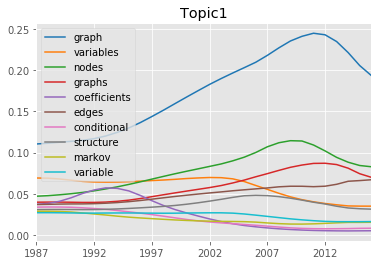

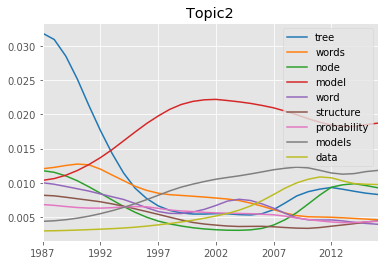

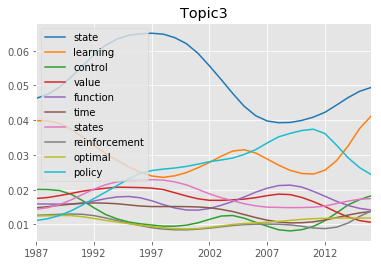

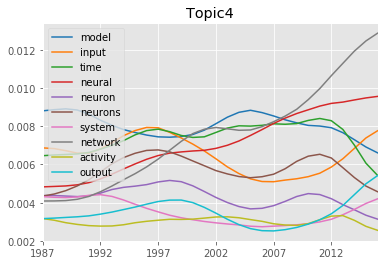

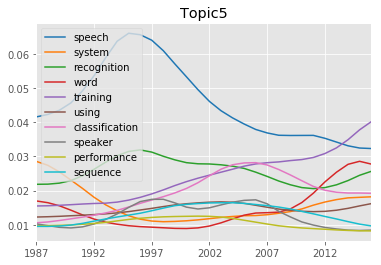

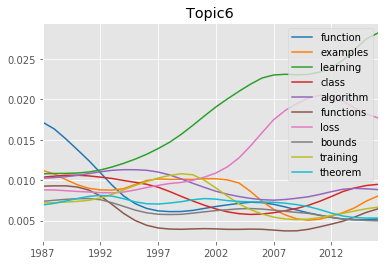

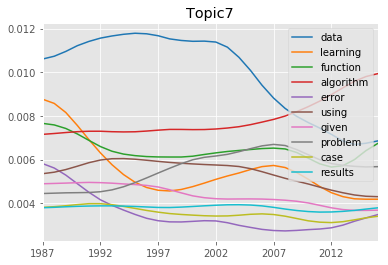

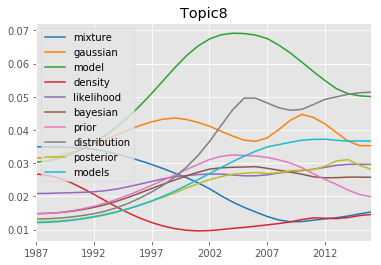

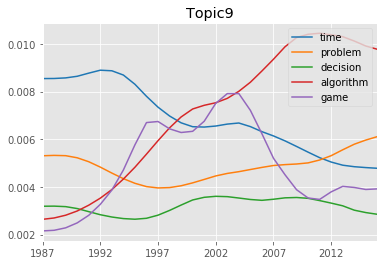

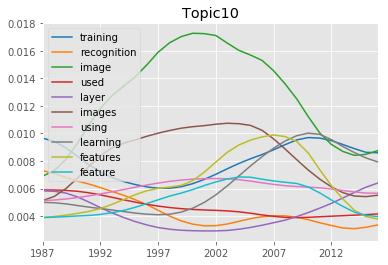

In [116]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# These are the "Tableau 10" colors as RGB.    
tableau10 = [(31, 119, 180), (255, 127, 14), (44, 160, 44),
             (214, 39, 40), (148, 103, 189), (140, 86, 75),    
             (227, 119, 194), (127, 127, 127), (188, 189, 34), (23, 190, 207)]  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau10)):    
    r, g, b = tableau10[i]    
    tableau10[i] = (r / 255., g / 255., b / 255.)   

for topic in range (1,11):
    input = '/Users/lillian/Documents/workspace/ir/topic'+str(topic)+'.csv'
    df = pd.read_csv(input, sep='\t')

    words = df['Topic'+str(topic)]
    probs = df.drop(['Topic'+str(topic)], axis=1)
    probs = probs[0:10]
    probs = probs.T
    probs = probs[1:31]
    ax = probs.plot(title='Topic'+str(topic), color=tableau10)
    ax.legend(words[0:10])

Still work on further explanation and visualization of the results... 